# Sklearn models for sarcasm on Reddit data

In [1]:
import json
import os
import pickle
import random
import warnings

import matplotlib.pyplot as plt

from scipy.sparse import hstack
from scipy.sparse.csr import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.utils import shuffle
from joblib import dump, load
from xgboost import XGBClassifier

from sarcsdet.configs.sklearn_models_config import *
from sarcsdet.configs.sklearn_models_grid_search_params import *
from sarcsdet.models.count_model_metrics import *

In [2]:
warnings.filterwarnings('ignore')

### Get data

In [3]:
data_path = '../data/Sarcasm_on_Reddit'

In [4]:
df = pd.read_pickle(os.path.join(data_path, 'rus-train-balanced-sarcasm-ling_feat.pkl'))

In [5]:
# split data to train and test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=8)

## Random

In [6]:
y_test = test_df.label
y_pred = [random.choice([0, 1]) for y in y_test]
y_pred_prob = [random.random() for y in y_test]

show_test_classification_metrics(y_test, y_pred, y_pred_prob)

F1: 0.50978
PREC: 0.51898
PR-AUC: 0.51864
ROC-AUC: 0.49927
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.50      0.49    119653
           1       0.52      0.50      0.51    129068

    accuracy                           0.50    248721
   macro avg       0.50      0.50      0.50    248721
weighted avg       0.50      0.50      0.50    248721

-------------------------------------------------------


## Train Sklearn models

In [7]:
result_path = '../results/reddit'

In [8]:
unsorted_scores = []

for filename in os.listdir(result_path):
    if filename.endswith('.json'):
        with open(os.path.join(result_path, filename)) as f:
            unsorted_scores.append(json.loads(f.read()))

In [9]:
scores_df = pd.io.json.json_normalize(unsorted_scores)
scores_df.rename(columns={
    'results.precision': 'precision', 'results.recall': 'recall', 'results.F1': 'F1', 
    'results.PR AUC': 'PR_AUC', 'results.ROC AUC': 'ROC_AUC'}, inplace=True
    )
scores_df.drop(columns=['seed', 'test samples'], axis=1, inplace=True)

In [10]:
scores_df = scores_df[scores_df['recall'] > 0.5]
scores_df = scores_df[scores_df['precision'] > 0.5]
scores_df = scores_df[scores_df['F1'] > 0.5]
scores_df = scores_df[scores_df['ROC_AUC'] > 0.5]

In [11]:
pd.set_option('display.max_colwidth', df.shape[0] + 1)
scores_df.sort_values(by=['precision'], ascending=False).head(15)

,embedding,model,extra_features,precision,recall,F1,PR_AUC,ROC_AUC
8,TFIDF,LogisticRegression,"[exclamation, question, quotes, dotes]",0.735356,0.671607,0.702037,0.793596,0.774353
71,TFIDF,LogisticRegression,[funny_mark],0.729030,0.665162,0.695633,0.786521,0.767301
58,TFIDF,LogisticRegression,[],0.728972,0.665154,0.695602,0.786475,0.767240
60,TFIDF,LogisticRegression,[interjections],0.728721,0.664790,0.695289,0.786488,0.767280
41,TFIDF,BernoulliNB,"[funny_mark, interjections, exclamation, question, quotes, dotes, author, subreddit, score]",0.723735,0.658911,0.689804,0.779186,0.757512
0,TFIDF,BernoulliNB,"[exclamation, question, quotes, dotes]",0.722344,0.655157,0.687112,0.777310,0.755042
47,TFIDF,BernoulliNB,"[author, subreddit, score]",0.720042,0.650969,0.683766,0.773785,0.751969
13,TFIDF,BernoulliNB,[],0.717978,0.647216,0.680763,0.771941,0.749482
35,TFIDF,BernoulliNB,[funny_mark],0.717892,0.647278,0.680759,0.772008,0.749583
70,TFIDF,BernoulliNB,[interjections],0.717638,0.647510,0.680773,0.771961,0.749464


## Get parameters for best Sklearn model

In [12]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 3), 
    max_features=50000,
    min_df=2
)

In [13]:
X = tfidf.fit_transform(train_df.rus_comment)
y = train_df.label.values

In [14]:
current_extra_features = [
    'funny_mark', 'interjections', 
    'exclamation', 'question', 'quotes', 'dotes'
]

extra_features_data = csr_matrix(train_df[current_extra_features].values.astype(np.float))
X = hstack([X, extra_features_data], format='csr')

In [15]:
cv = KFold(n_splits=5, shuffle=True)

In [16]:
clf = LogisticRegression(**default_logit_params_rus)  # --> lr_grid
# clf = XGBClassifier(**default_xgb_params_rus)  # --> xgb_grid
# clf = BernoulliNB(**default_bayes_params_rus)  # --> nb_grid

In [17]:
scoring = {
    'PREC': 'precision',
    'PR_AUC': 'average_precision',
    'AUC': 'roc_auc',  
    'F1': 'f1_weighted'
}

In [18]:
gs = GridSearchCV(
    clf, lr_grid, 
    scoring=scoring, cv=cv, 
    refit='AUC',
    verbose=10, n_jobs=6
)

In [19]:
search = gs.fit(X, y)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


In [20]:
best_estimator = gs.best_estimator_
best_estimator

LogisticRegression(C=1, class_weight='balanced', multi_class='ovr', n_jobs=-2,
                   solver='newton-cg')

In [21]:
get_best_model_metrics(X, y, cv, best_estimator)


F1: 0.70074
ROC-AUC: 0.77321
ACCURACY: 0.7028
PR-AUC: 0.79335


F1: 0.69972
PREC: 0.73401
PR-AUC: 0.79161
ROC-AUC: 0.77215
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.74      0.70    119653
           1       0.73      0.67      0.70    129068

    accuracy                           0.70    248721
   macro avg       0.70      0.70      0.70    248721
weighted avg       0.71      0.70      0.70    248721

-------------------------------------------------------


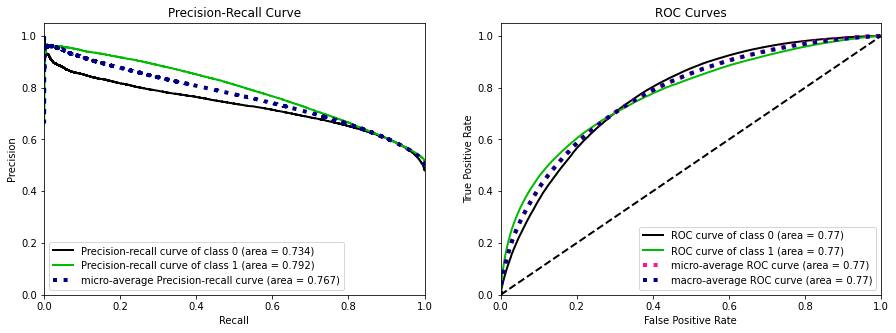

In [22]:
X_test = tfidf.transform(test_df.rus_comment)

test_extra_features_data = csr_matrix(test_df[current_extra_features].values.astype(np.float))
X_test = hstack([X_test, test_extra_features_data], format='csr')

probas = best_estimator.predict_proba(X_test)
show_test_classification_metrics(
    test_df.label.values, 
    best_estimator.predict(X_test), 
    probas[:, 1], 
    X_test, 
    best_estimator,
    probas,
)

In [23]:
dump(tfidf, '../data/Models/reddit/tfidf.joblib')

['../data/Models/reddit/tfidf.joblib']

In [24]:
dump(best_estimator, '../data/Models/reddit/LogisticRegression.joblib')

['../data/Models/reddit/LogisticRegression.joblib']